In [1]:
import os
import keras
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.api.models import load_model, Sequential
from keras.api.layers import Dense, Dropout
from keras.api.optimizers import SGD, Adam
from keras.api.losses import SparseCategoricalCrossentropy
from keras import layers, activations, Model
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

2024-11-02 21:39:28.248437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 21:39:28.263251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 21:39:28.267456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 21:39:28.277730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 21:39:29.116900: W tensorflow/compiler/tf2

In [2]:
# We can customize the batch size, image height, and image width
batch_size  = 32
img_height  = 224
img_width   = 224
channel     = 3

image_size              = (img_height, img_width)
image_size_with_channel = (img_height, img_width, channel)

# Constant value
CHECKPOINTS = "checkpoints"
LATEST_MODEL_NAME = "latest_model.keras"

# Using default sort from VSCode
# Colon polyps, Colorectal cancer, Normal mucosa...
CLASS_ARR = ["Colon polyps", "Colorectal cancer", "Normal mucosa and vascular pattern in the large bowel"]

In [3]:
# Save the current model
def save_model(model, model_name: str = ""):
    try:
        model.save(CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME)
    except Exception as e:
        print(e)
        raise e
    
    print("Model has succesfully saved")
    
def load_model_function(model_name):
    try:
        model_file = CHECKPOINTS + os.sep + model_name
        model = load_model(model_file)

        return model
    except Exception as e:
        raise e

In [4]:
def make_evaluation_metrics(model: Model, validation_dataset: tf.data.Dataset):
    predictions = np.array([])
    labels = np.array([])
    categories = CLASS_ARR

    for x, y in validation_dataset:
        y_pred = model.predict(x)
        y_prediction = np.argmax(y_pred, axis=1)
        predictions = np.concatenate([predictions, y_prediction])
        labels = np.concatenate([labels, y.numpy()])

    print("---------------EVALUATION METRICS---------------")

    print(f"Accuracy Score:     {accuracy_score(y_true=labels, y_pred=predictions)}")
    print(f"Precision Score:    {precision_score(y_true=labels, y_pred=predictions, average=None)}")
    print(f"Recall Score:       {recall_score(y_true=labels, y_pred=predictions, average=None)}")
    print(f"F1 Score:           {f1_score(y_true=labels, y_pred=predictions, average=None)}")

    print("----------------CONFUSION MATRIX----------------")

    plt.figure(num=69420, figsize=(plt.rcParams.get('figure.figsize')))
    sns.heatmap(confusion_matrix(y_true=labels, y_pred=predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt="d")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

In [5]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/preprocessed_Gastrovision/training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/preprocessed_Gastrovision/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1942 files belonging to 3 classes.


I0000 00:00:1730558374.148872   15125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730558374.178396   15125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730558374.178588   15125 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730558374.179266   15125 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 484 files belonging to 3 classes.


In [6]:
image_augmentation = {
    "training": Sequential([
        layers.RandomRotation(factor=0.2),
        layers.RandomFlip(),
    ])
}

In [7]:
# Pretrained models
densenet_model = keras.applications.DenseNet169(
    include_top=False,
    classes=3,
    input_shape=(img_height, img_width, channel)
)

In [8]:
# freeze the model
densenet_model.trainable = False

for layer in densenet_model.layers[-10:]:
    layer.trainable = True

In [9]:
inputs = keras.Input(shape=image_size_with_channel)
x = image_augmentation["training"](inputs)
x = keras.applications.densenet.preprocess_input(x)
x = densenet_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64)(x)
x = keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(units=3, activation=activations.softmax)(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       426,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,112,259 (50.02 MB)

 Trainable params: 721,091 (2.75 MB)

 Non-trainable params: 12,391,168 (47.27 MB)

In [10]:
def get_early_stopping():
    return keras.callbacks.EarlyStopping(patience=5)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [12]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[get_early_stopping()])

Epoch 1/10


2024-11-02 21:40:07.263890: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730558407.324853   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558407.360353   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558407.364947   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558407.370587   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558407.376416   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558407.388749   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558407.400084   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558407.410950   15211 gpu_t

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.3684 - loss: 1.7163

W0000 00:00:1730558427.251940   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558427.254930   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558427.257978   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558427.261320   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558427.264679   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558427.269720   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558427.276108   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558427.281632   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558427.288080   15211 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3689 - loss: 1.7145

W0000 00:00:1730558431.128703   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558431.130184   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558431.131716   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558431.145982   15209 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558431.147281   15209 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558431.148537   15209 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558431.149681   15209 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558431.150850   15209 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558431.152018   15209 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 53s 493ms/step - accuracy: 0.3695 - loss: 1.7127 - val_accuracy: 0.6963 - val_loss: 0.7968
Epoch 2/10


W0000 00:00:1730558442.078331   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558442.079534   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558442.085152   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558442.086311   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558442.087437   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558442.088554   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558442.089717   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558442.090872   15211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730558442.092069   15211 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.4889 - loss: 1.3193 - val_accuracy: 0.7314 - val_loss: 0.7937
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step - accuracy: 0.5680 - loss: 1.1125 - val_accuracy: 0.7376 - val_loss: 0.8293
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - accuracy: 0.5861 - loss: 1.0215 - val_accuracy: 0.7831 - val_loss: 0.6578
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.6519 - loss: 0.8684 - val_accuracy: 0.7686 - val_loss: 0.7198
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.6431 - loss: 0.8662 - val_accuracy: 0.8140 - val_loss: 0.6373
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - accuracy: 0.6934 - loss: 0.7498 - val_accuracy: 0.8079 - val_loss: 0.6287
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.7496 - loss: 0.6784 - val_accuracy: 0.8347 - val_loss: 0.5228
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 310ms/step - accuracy: 0.7679 - loss: 0.6708 - val_accuracy: 0.838

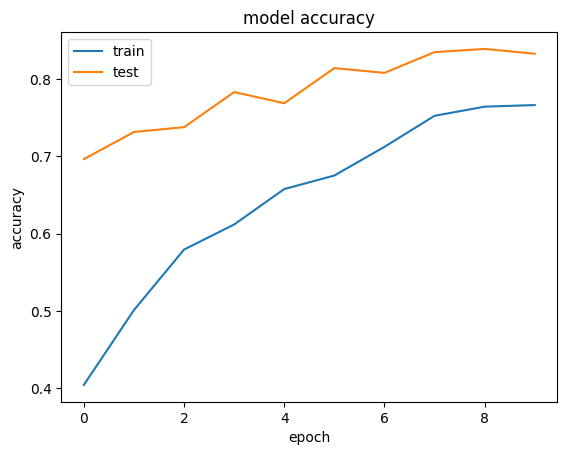

In [13]:
# show training accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

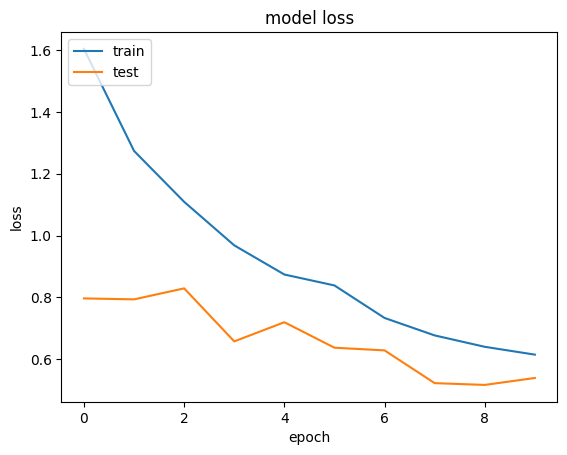

In [14]:
# show training loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# save_model(model, "densenet169_feature-extraction")
save_model(model, "densenet169_transfer-learning")

Model has succesfully saved


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
---------------EVALUATION METRICS---------------
Accuracy Score:     0.8326446280991735
Precision Score:    [0.72164948 0.7        0.91428571]
Recall Score:       [0.85365854 0.25925926 0.87372014]
F1 Score:           [0.78212291 0.37837838 0.89354276]
----------------CONFUSION MATRIX----------------


2024-11-02 21:43:56.241734: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


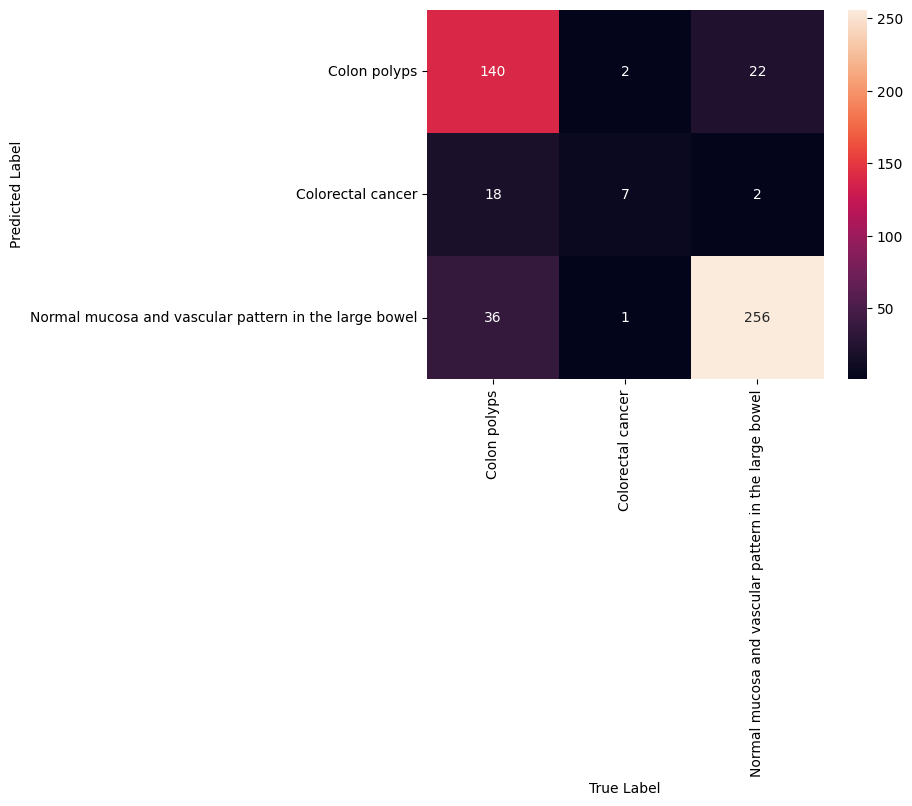

In [16]:
make_evaluation_metrics(model, val_ds)